<a href="https://colab.research.google.com/github/VALQUIRIAFABRO/Deep_learning/blob/master/RNN_DeepLearning_breast_cancer_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Implementação de uma RNN

In [1]:
#Importando libraries de interesse
import pandas as pd
import numpy as np
import matplotlib #library para gráficos
import matplotlib.pyplot as plt
import sklearn #library de machine learning
from sklearn.datasets import load_breast_cancer #dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import time #Infos de tempo

### Função Para Inicialização de Pesos

In [2]:
# Função para inicialização randômica dos parâmetros do modelo
def inicializa_parametros(dims_camada_entrada):
    
    # Dicionário para os parâmetros
    parameters = {}
    
    # Comprimento das dimensões das camadas
    comp = len(dims_camada_entrada)
    
    # Loop pelo comprimento
    for i in range(1, comp):
        
        # Inicialização da matriz de pesos
        parameters["W" + str(i)] = np.random.randn(dims_camada_entrada[i], dims_camada_entrada[i - 1]) * 0.01
        
        # Inicialização do bias
        parameters["b" + str(i)] = np.zeros((dims_camada_entrada[i], 1))
    
    return parameters

In [3]:
# Função sigmóide
'''
Utilizamos a função sigmóide pois permite converter números para valores entre 0 e 1.
Usada para modelos em que temos que prever a probabilidade como uma saída, sendo qualquer item existente no intervalo entre 0 e 1.
'''
def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    return A, Z

In [4]:
# Função de ativação ReLu (Rectified Linear Unit)
'''
Fynção de ativação para utilizarmos na descida do SGD com retropropagação de erros.
'''
def relu(Z):
    A = abs(Z * (Z > 0))
    return A, Z

In [5]:
# Operação de ativação
def linear_activation(A, W, b):
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    return Z, cache

#"A": matriz com os dados de entrad / "W": matriz de pesos / "b": bias

### Forward Propagation

In [6]:
# Movimento forward
def forward(A_prev, W, b, activation):
    
    # Se a função de ativação for Sigmoid
    if activation == "sigmoid":
        Z, linear_cache = linear_activation(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
        
    # Se for ReLu    
    elif activation == "relu":
        Z, linear_cache = linear_activation(A_prev, W, b)
        A, activation_cache = relu(Z)
        
    cache = (linear_cache, activation_cache)
    
    return A, cache

In [8]:
#Combinando Ativação e Propagação

# Propagação forward
def forward_propagation(X, parameters):
    
    # Lista de valores anteriores (cache)
    caches = []
    
    # Dados de entrada
    A = X
    
    # Comprimento dos parâmetros
    L = len(parameters) // 2
   
    # Loop
    for i in range(1, L):
      
        # Guarda o valor prévio de A
        A_prev = A
        
        # Executa o forward
        A, cache = forward(A_prev, parameters["W" + str(i)], parameters["b" + str(i)], activation = "relu")
        
        # Grava o cache
        caches.append(cache)
    
    # Saída na última camada
    A_last, cache = forward(A, parameters["W" + str(L)], parameters["b" + str(L)], activation = "sigmoid")
    
    # Grava o cache
    caches.append(cache)
    
    return(A_last, caches)

### Função de Custo (Cost Function)

In [9]:
def calc_custo(A_last, Y):
    
    # Ajusta o shape de Y para obter seu comprimento (total de elementos)
    m = Y.shape[1]
    
    # Calcula o custo comparando valor real e previso
    custo = (-1 / m) * np.sum((Y * np.log(A_last)) + ((1 - Y) * np.log(1 - A_last)))
    
    # Ajusta o shape do custo
    custo = np.squeeze(custo)
    
    return(custo)

### Backward Propagation - Função Sigmóide Backward

In [10]:
# Função sigmoid para o backpropagation 
# Cálculo da derivada pois temos interessa na informação relacionada a sua variação
def sigmoid_backward(da, Z):
    
    # Calculo da derivada de Z
    dg = (1 / (1 + np.exp(-Z))) * (1 - (1 / (1 + np.exp(-Z))))
    
    # Identificação da alteração na derivada de z
    dz = da * dg
    return dz

#### Backward Propagation - Função ReLu Backward

In [11]:
def relu_backward(da, Z):
    
    dg = 1 * ( Z >= 0)
    dz = da * dg
    return dz

#Os interesses são os mesmos da função sigmóide no que se refere a informação d avriação.

### Backward Propagation - Ativação Linear Backward

In [12]:
def linear_backward_function(dz, cache):
    
    # Recebe valor da memória (cache)
    A_prev, W, b = cache
    
    # Shape de m
    m = A_prev.shape[1]
    
    # Calculo da derivada de W (Result. operação com dz)
    dW = (1 / m) * np.dot(dz, A_prev.T)
    
    # Calculo da derivada de b (Result. operação com dz)
    db = (1 / m) * np.sum(dz, axis = 1, keepdims = True)
    
    # Calculo da derivada da operação
    dA_prev = np.dot(W.T, dz)
    
    return dA_prev, dW, db

### Backward Propagation - Ativação Linear Backward

In [13]:
# Tipo de ativação (relu ou sigmoid)
def linear_activation_backward(dA, cache, activation):
    
    # Extrai o cache
    linear_cache, activation_cache = cache
    
    # Verifica se é ReLu
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward_function(dZ, linear_cache)
        
    # Verifica se é Sigmoid
    if activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward_function(dZ, linear_cache)
        
    return dA_prev, dW, db

### Algoritmo Backpropagation

In [14]:
def backward_propagation(AL, Y, caches):
    
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    
    # Ajusta o shape de Y
    Y = Y.reshape(AL.shape)
    
    # Calcula a derivada da previsão final da rede(ForwardPropagation) e em seguida recupera o valor atual do cache
    dAL = -((Y / AL) - ((1 - Y) / (1 - AL)))
    current_cache = caches[L - 1]
    
    # Geração da a lista de gradiente para: dados, pesos e bias
    grads["dA" + str(L - 1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
    # Loop para calculao durante as ativações utilizando a ReLu
    for l in reversed(range(L - 1)):
        
        # Memória atual + Calc de derivadas.
        current_cache = caches[l]
        dA_prev, dW, db = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        
        # Dá infos para os gradientes, usando o índice relacionado
        grads["dA" + str(l)] = dA_prev
        grads["dW" + str(l + 1)] = dW
        grads["db" + str(l + 1)] = db
        
    return grads

### Gradientes e Pesos

In [15]:
# Atualização de pesos
def atualiza_pesos(parameters, grads, learning_rate):
    
    # Comprimento da estrutura de dados com os parâmetros (pesos e bias)
    L = len(parameters)//2
    
    # Loop para atualização dos pesos
    for l in range(L):
        
        # Atualização dos pesos
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - (learning_rate * grads["dW" + str(l + 1)])
        
        # Atualização do bias
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - (learning_rate * grads["db" + str(l + 1)])
    
    return parameters

#### Implementação da Rede

In [16]:
# Modelo completo da rede neural
def modeloNN(X, Y, dims_camada_entrada, learning_rate = 0.0075, num_iterations = 100):
    #Vejam o tamanho do learning_rate. Comentei durante em aula que as taxas são realmente baixas.
    
    # Lista para receber o custo a cada epoch em train
    custos = []
    
    # Inicializa parâmetros
    parametros = inicializa_parametros(dims_camada_entrada)
    
    # Loop pelo número de iterações (epochs)
    for i in range(num_iterations):
        
        # Forward Propagation
        AL, caches = forward_propagation(X, parametros)
        
        # Calculo do custo
        custo = calc_custo(AL, Y)
        
        # Backward Propagation
        gradientes = backward_propagation(AL, Y, caches)
        
        # Atualização depesos
        parametros = atualiza_pesos(parametros, gradientes, learning_rate)
        
        # Print do valor intermediário do custo, sendo que a redução do custo indica o aprendizado do modelo
        if i % 10 == 0:
            print("Custo Após " + str(i) + " iterações é " + str(custo))
            custos.append(custo)
            
    return parametros, custos 

In [19]:
# Função para fazer as previsões

def predict(X, parametros):
    AL, caches = forward_propagation(X, parametros)
    return AL

# Notem que não há backpropagation, pois conforme as previsões surgem, os valores dos pesos mais aderentes acabam ficando conhecidos.

In [20]:
#Para informações do dataset
#Carregamos o conjunto

cancer = load_breast_cancer()
print(type(cancer))

<class 'sklearn.utils.Bunch'>


In [21]:
cancerDF = pd.DataFrame(columns = load_breast_cancer()["feature_names"], data = load_breast_cancer()["data"])

In [22]:
cancerDF.shape

(569, 30)

In [23]:
cancerDF.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [24]:
#identificamos e separamos nosso target
target = load_breast_cancer()["target"]

In [25]:
type(target)

numpy.ndarray

In [26]:
target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,

In [27]:
print("Total da classe do tipo Benigno", np.count_nonzero(target == 1))
print("="*15)
print("Total da classe do tipo Maligno", np.count_nonzero(target == 0))

Total da classe do tipo Benigno 357
Total da classe do tipo Maligno 212


In [28]:
#Dicionário para os labels
labels = {}

#Nomes das classes da variável target
target_names = load_breast_cancer()["target_names"]

for i in range(len(target_names)):
    labels.update({i:target_names[i]})

In [29]:
labels

{0: 'malignant', 1: 'benign'}

In [30]:
#Entregamos as variáveis preditoras para X
X = np.array(cancerDF)

In [31]:
#Divisão de dados de entrada e saída em treino e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, target, test_size = 0.2, shuffle = True)

In [32]:
#Verificação de estados dos nossos dados X,y (Treino)
print("Dados de Treino")
print(X_treino.shape)
print(y_treino.shape)
print("="*20)
print("Dados de Teste")
print(X_teste.shape)
print(y_teste.shape)

Dados de Treino
(455, 30)
(455,)
Dados de Teste
(114, 30)
(114,)


In [33]:
#Ajuste nos dados de entrada

X_treino = X_treino.T
X_teste = X_teste.T

#Ajuste nos dados de saída
y_treino = y_treino.reshape(1,len(y_treino))
y_teste = y_teste.reshape(1,len(y_teste))

In [34]:
#Dimensões de entrada com número de neurônips
dims_camada_entrada = [X_treino.shape[0], 50, 20, 5, 1]

In [35]:
iniProc = time.time()
parametros, custo = modeloNN(X = X_treino,
                             Y = y_treino,
                             dims_camada_entrada = dims_camada_entrada,
                            num_iterations = 3000,
                            learning_rate = 0.0075)
print("Treinamento durou %2.f segundos " % (time.time() - iniProc))

Custo Após 0 iterações é 0.6931635700441897
Custo Após 10 iterações é 0.69228734468398
Custo Após 20 iterações é 0.6914429975941695
Custo Após 30 iterações é 0.6906293257012693
Custo Após 40 iterações é 0.6898451638142956
Custo Após 50 iterações é 0.6890893869008248
Custo Após 60 iterações é 0.6883609046169807
Custo Após 70 iterações é 0.6876586582988348
Custo Após 80 iterações é 0.6869816213214367
Custo Após 90 iterações é 0.6863287991923764
Custo Após 100 iterações é 0.6856992163615327
Custo Após 110 iterações é 0.6850919277724354
Custo Após 120 iterações é 0.6845064422368082
Custo Após 130 iterações é 0.6839418735458312
Custo Após 140 iterações é 0.6833970672972579
Custo Após 150 iterações é 0.6828711845095171
Custo Após 160 iterações é 0.6823633603265715
Custo Após 170 iterações é 0.681872746877017
Custo Após 180 iterações é 0.6813984977009561
Custo Após 190 iterações é 0.6809397373356397
Custo Após 200 iterações é 0.6804955696828094
Custo Após 210 iterações é 0.6800650907554822
Cu

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0.5, 1.0, 'Erros em Treinamento')

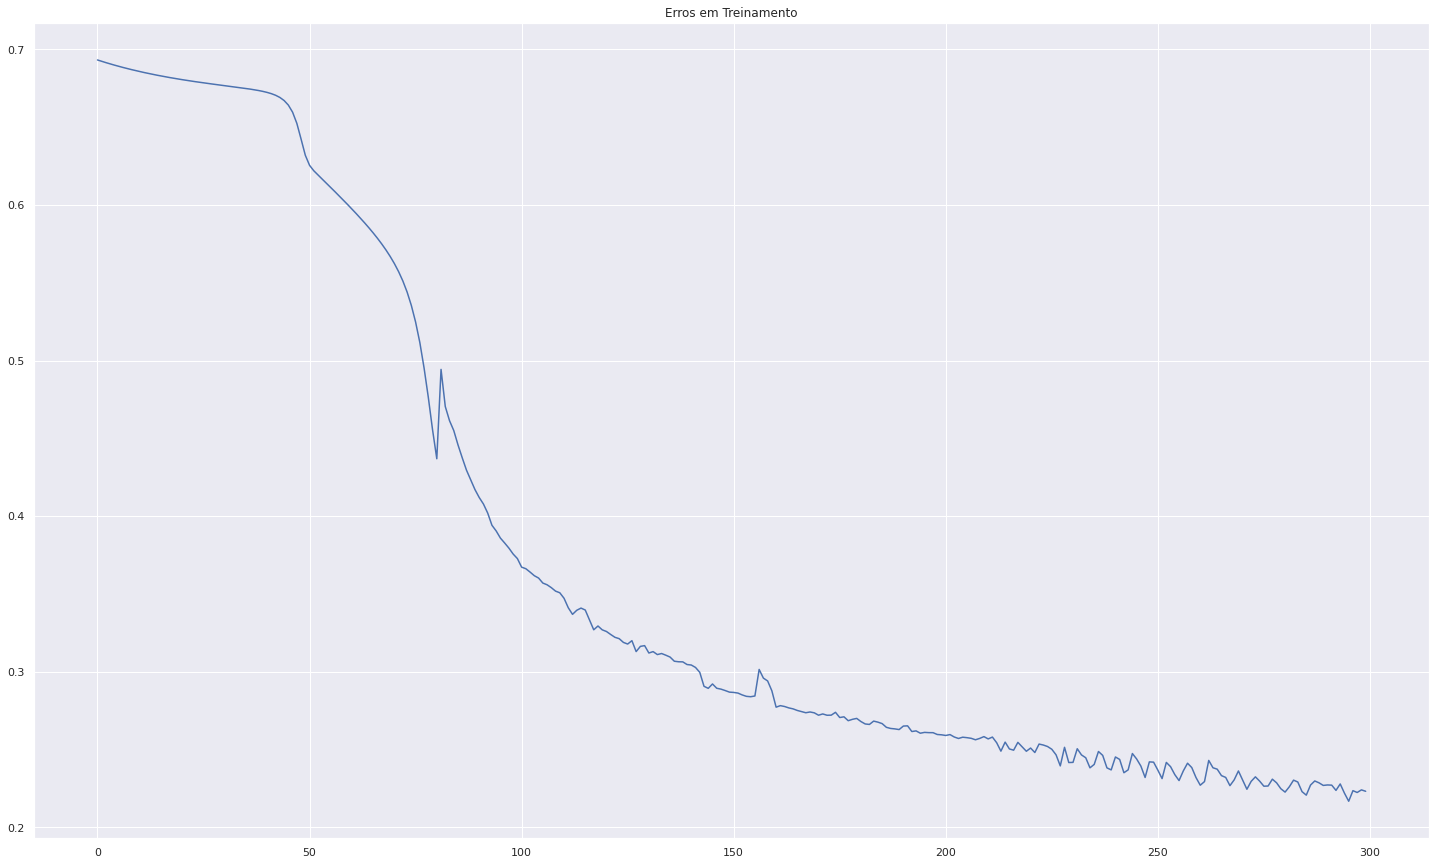

In [36]:
import seaborn as sns
#Plot do erro no treinamento
sns.set(rc={"figure.figsize":(25,15)});
plt.plot(custo)
plt.title("Erros em Treinamento")

In [37]:
#Previsões em treino
y_pred_treino = predict(X_treino, parametros)

In [38]:
#Visualização das previsões
y_pred_treino

array([[7.13005233e-05, 2.34458041e-01, 4.67565864e-10, 8.80667809e-01,
        4.06785928e-01, 3.87895022e-01, 1.47614781e-02, 8.49899468e-01,
        6.88856284e-01, 8.14836289e-01, 8.31417646e-09, 1.84876921e-01,
        8.28165654e-01, 8.80667474e-01, 8.72287508e-01, 1.74378452e-13,
        8.60329441e-01, 8.80668054e-01, 8.02001719e-01, 8.80668106e-01,
        1.17616829e-04, 8.80667383e-01, 8.30654165e-01, 8.80668071e-01,
        8.75361468e-01, 6.49185112e-02, 4.37286133e-07, 7.26386910e-01,
        8.61243819e-01, 8.80668214e-01, 1.49071438e-09, 6.86566342e-01,
        8.80667908e-01, 2.86516094e-06, 2.51753818e-09, 1.01258003e-04,
        8.80667383e-01, 8.80667798e-01, 8.80667864e-01, 6.73432010e-01,
        8.46330353e-01, 1.44520605e-10, 5.53661123e-01, 1.44453955e-01,
        9.95314640e-03, 8.80667995e-01, 1.31109916e-03, 8.76199571e-01,
        7.77878891e-01, 8.80667968e-01, 8.31989493e-01, 2.10546352e-08,
        8.80668073e-01, 8.80667896e-01, 6.28923419e-01, 7.615282

In [39]:
#Ajustamos o shape para treino
y_pred_treino = y_pred_treino.reshape(-1)
y_treino = y_treino.reshape(-1)
y_pred_treino > 0.5

array([False, False, False,  True, False, False, False,  True,  True,
        True, False, False,  True,  True,  True, False,  True,  True,
        True,  True, False,  True,  True,  True,  True, False, False,
        True,  True,  True, False,  True,  True, False, False, False,
        True,  True,  True,  True,  True, False,  True, False, False,
        True, False,  True,  True,  True,  True, False,  True,  True,
        True,  True, False,  True,  True, False,  True, False,  True,
        True, False,  True,  True, False, False,  True, False,  True,
        True,  True,  True,  True,  True, False,  True,  True, False,
        True, False,  True,  True, False,  True,  True, False,  True,
        True,  True,  True,  True, False,  True,  True, False, False,
       False,  True, False, False, False,  True,  True,  True, False,
       False, False,  True,  True,  True, False,  True, False,  True,
       False,  True,  True,  True,  True, False,  True,  True,  True,
        True, False,

In [40]:
#Conversão das previsões binário de classe (0 ou 1), usando como threshold o valor de 0.5 da probabilidade
y_pred_treino = (1 * (y_pred_treino) > 0.5)
y_pred_treino

array([False, False, False,  True, False, False, False,  True,  True,
        True, False, False,  True,  True,  True, False,  True,  True,
        True,  True, False,  True,  True,  True,  True, False, False,
        True,  True,  True, False,  True,  True, False, False, False,
        True,  True,  True,  True,  True, False,  True, False, False,
        True, False,  True,  True,  True,  True, False,  True,  True,
        True,  True, False,  True,  True, False,  True, False,  True,
        True, False,  True,  True, False, False,  True, False,  True,
        True,  True,  True,  True,  True, False,  True,  True, False,
        True, False,  True,  True, False,  True,  True, False,  True,
        True,  True,  True,  True, False,  True,  True, False, False,
       False,  True, False, False, False,  True,  True,  True, False,
       False, False,  True,  True,  True, False,  True, False,  True,
       False,  True,  True,  True,  True, False,  True,  True,  True,
        True, False,

In [41]:
aval_treino = sum(1 * (y_pred_treino == y_treino)) / len(y_pred_treino) * 100
print("Acurácia em Treino: " + str(aval_treino))

Acurácia em Treino: 92.08791208791209


In [42]:
print(classification_report(y_treino, y_pred_treino, target_names = ['Maligno', 'Benigno']))

              precision    recall  f1-score   support

     Maligno       0.91      0.89      0.90       178
     Benigno       0.93      0.94      0.94       277

    accuracy                           0.92       455
   macro avg       0.92      0.91      0.92       455
weighted avg       0.92      0.92      0.92       455



In [43]:
#Previsões usando dados de teste
y_pred_teste = predict(X_teste, parametros)
y_pred_teste

array([[8.80668109e-01, 8.80667900e-01, 8.68636195e-01, 3.08275515e-07,
        8.73153676e-01, 6.39052690e-01, 8.80668063e-01, 6.77989194e-01,
        8.80667383e-01, 2.16105724e-01, 8.32598494e-01, 8.80667962e-01,
        8.80667936e-01, 8.61301033e-01, 4.09261601e-24, 1.48533200e-09,
        6.09105271e-04, 7.64530252e-01, 8.80667978e-01, 8.80667485e-01,
        8.80667926e-01, 8.78157698e-01, 8.80667999e-01, 8.46125428e-01,
        8.80667383e-01, 8.17937203e-01, 8.01780533e-01, 8.80667867e-01,
        8.66399650e-01, 8.14416220e-01, 8.80667959e-01, 4.86759845e-01,
        8.80667814e-01, 7.71433752e-01, 7.59377925e-01, 8.74630620e-01,
        8.28495708e-01, 5.52131194e-02, 3.90532514e-01, 8.80668063e-01,
        8.80667576e-01, 2.03751354e-01, 8.13690372e-01, 8.80519981e-01,
        8.79086444e-01, 4.59715312e-02, 3.14334138e-03, 8.47418754e-01,
        8.72651262e-01, 8.11989363e-01, 6.94183333e-08, 8.79575552e-01,
        8.80667658e-01, 7.79350899e-01, 8.70753711e-01, 2.591785

In [44]:
#Ajuste dos shapes
y_pred_teste = y_pred_teste.reshape(-1)
y_teste =y_teste.reshape(-1)

#Conversão das previsões binário
y_pred_teste = 1* (y_pred_teste > 0.5)

y_pred_teste

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 0])

In [45]:
#Acurácia
acuraciaFim = sum(1* (y_pred_teste == y_teste)) / len(y_pred_teste) * 100
print("Acurácia em dados de Teste: "+ str(acuraciaFim))

Acurácia em dados de Teste: 92.98245614035088


In [46]:
print(classification_report(y_teste, y_pred_teste, target_names = ['Maligno', 'Benigno']))

              precision    recall  f1-score   support

     Maligno       0.91      0.85      0.88        34
     Benigno       0.94      0.96      0.95        80

    accuracy                           0.93       114
   macro avg       0.92      0.91      0.91       114
weighted avg       0.93      0.93      0.93       114

